In [49]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.covariance import LedoitWolf

import matplotlib.pyplot as plt
import seaborn as sns


In [50]:
TICKERS = ["NVDA", "AAPL", "MSFT", "AMZN", "2222.SR", "META", "TSLA", "TSM", "AVGO"]

# Data range
START_DATE = "2000-01-01"
END_DATE   = "2025-01-01"

INPUT_WINDOW   = 60   # more days of past returns
LOOKAHEAD_DAYS = 60   # future window for realized covariance
ADD_ROLLING_VOL_FEATURE = True  
VOL_WINDOW = 10   

TRAIN_RATIO  = 0.7
VALID_RATIO  = 0.15    # effectively: Train=70%, Val=10%, Test=20%

NUM_EPOCHS   = 40     # more epochs t
BATCH_SIZE   = 16

N_FACTORS    = 2     
HIDDEN_SIZE  = 128
NUM_LAYERS   = 2

LEARNING_RATE = 2e-3
WEIGHT_DECAY  = 1e-5 

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
np.random.seed(42)

print("Using device:", DEVICE)

Using device: cpu


In [51]:
# 3.1 Download data
df_prices = yf.download(TICKERS, start=START_DATE, end=END_DATE, progress=False)["Adj Close"]
df_prices.dropna(inplace=True)

print("Data shape:", df_prices.shape)


Data shape: (973, 9)


In [52]:
df_returns = df_prices.pct_change().dropna()
print("Returns shape:", df_returns.shape)

Returns shape: (972, 9)


In [53]:
def compute_rolling_volatility(returns, vol_window=20):
    """
    Compute rolling volatility for each asset.
    returns: pd.DataFrame of daily returns (shape: days x assets).
    vol_window: Rolling window size for volatility calculation.
    """
    rolling_vol = returns.rolling(window=vol_window).std().dropna()
    return rolling_vol


In [54]:
# Optional Extra Feature: Rolling Volatility

if ADD_ROLLING_VOL_FEATURE:
    df_vol = df_returns.rolling(VOL_WINDOW).std().fillna(0.0)
    # rename columns to avoid collisions
    vol_cols = [f"{col}_vol" for col in df_vol.columns]
    df_vol.columns = vol_cols
    # concat returns + vol side by side
    df_features = pd.concat([df_returns, df_vol], axis=1)
else:
    df_features = df_returns.copy()

print("Feature DataFrame shape:", df_features.shape)
print("Columns:", df_features.columns)

n_assets = len(TICKERS)
if ADD_ROLLING_VOL_FEATURE:
    # each asset has 2 columns (return + vol)
    input_size = n_assets * 2
else:
    input_size = n_assets

Feature DataFrame shape: (972, 18)
Columns: Index(['2222.SR', 'AAPL', 'AMZN', 'AVGO', 'META', 'MSFT', 'NVDA', 'TSLA',
       'TSM', '2222.SR_vol', 'AAPL_vol', 'AMZN_vol', 'AVGO_vol', 'META_vol',
       'MSFT_vol', 'NVDA_vol', 'TSLA_vol', 'TSM_vol'],
      dtype='object')


In [55]:

# For each day t, label = covariance( [t+1 .. t+LOOKAHEAD_DAYS] ).
# use LedoitWolf
def compute_shrunk_cov_labels(returns_df, look_ahead=20):
    """
    returns_df: shape (num_days, n_assets) of daily returns
    look_ahead: how many future days to compute realized covariance
    """
    cov_labels = []
    n_assets_ = returns_df.shape[1]
    # We'll generate labels for i in [0 .. len- look_ahead]
    for i in range(len(returns_df) - look_ahead):
        
        future_slice = returns_df.iloc[i+1 : i+1+look_ahead]
        
        lw = LedoitWolf().fit(future_slice.values)
        shrunk_cov = lw.covariance_  
        
        cov_labels.append(shrunk_cov)
    return np.array(cov_labels)

labels_cov = compute_shrunk_cov_labels(df_returns, LOOKAHEAD_DAYS)
print("labels_cov shape:", labels_cov.shape)


labels_cov shape: (912, 9, 9)


In [56]:
# Build feature windows (X_features) with the same length

X_list = []
for i in range(len(df_features) - LOOKAHEAD_DAYS):
    # index i in the label corresponds to data up to day i
    if i < INPUT_WINDOW:
        window_data = np.zeros((INPUT_WINDOW, input_size))
    else:
        window_data = df_features.iloc[i - INPUT_WINDOW : i].values
    
    X_list.append(window_data)

X_array = np.array(X_list)  
print("X_array shape:", X_array.shape)

assert len(X_array) == len(labels_cov), "Mismatch in features vs. labels length."


X_array shape: (912, 60, 18)


In [57]:
# Training split

total_samples = len(labels_cov)
train_end = int(total_samples * TRAIN_RATIO)
val_end   = int(total_samples * (TRAIN_RATIO + VALID_RATIO))

X_train = X_array[:train_end]
y_train = labels_cov[:train_end]

X_val = X_array[train_end:val_end]
y_val = labels_cov[train_end:val_end]

X_test = X_array[val_end:]
y_test = labels_cov[val_end:]

print("TRAIN samples:", len(X_train))
print("VAL samples:  ", len(X_val))
print("TEST samples: ", len(X_test))

TRAIN samples: 638
VAL samples:   137
TEST samples:  137


In [58]:
class FactorCovModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_assets, n_factors, dropout_prob):
        """
        input_size  = number of features per timestep (e.g., n_assets or n_assets*2 if vol added)
        hidden_size = LSTM hidden state size
        num_layers  = number of LSTM layers
        n_assets    = number of assets
        n_factors   = number of factors (K)
        dropout_prob = dropout probability
        """
        super().__init__()
        self.n_assets = n_assets
        self.n_factors = n_factors

        # Add dropout between lSTM layers if num_layers > 1
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob if num_layers > 1 else 0.0
        )
        # # loadings + factor_vars + idio_vars
        self.out_dim = (n_assets*n_factors) + n_factors + n_assets
        self.fc = nn.Linear(hidden_size, self.out_dim)

        #Dropout after LSTM before FC layer
        self.dropout = nn.Dropout(p=dropout_prob)
    def forward(self, x):
        """
        x shape: (batch_size, seq_len=INPUT_WINDOW, input_size)
        Return: (batch_size, n_assets, n_assets)
        """
        batch_size = x.size(0)

        
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]  # final timestep
        last_out = self.dropout(last_out)   
        raw_out = self.fc(last_out)   
        
        idx = 0
        loadings_size   = self.n_assets * self.n_factors
        factor_var_size = self.n_factors
        idio_var_size   = self.n_assets
        
        loadings_flat  = raw_out[:, idx : idx+loadings_size]
        idx += loadings_size
        factor_log_var = raw_out[:, idx : idx+factor_var_size]
        idx += factor_var_size
        idio_log_var   = raw_out[:, idx : idx+idio_var_size]
        idx += idio_var_size
        
        # Reshape loadings
        loadings = loadings_flat.view(batch_size, self.n_assets, self.n_factors)

        factor_vars = torch.exp(factor_log_var)
        idio_vars   = torch.exp(idio_log_var)

        # Construct covariance matrix: Sigma = L diag(factor_vars) L^T + diag(idio_vars)
        Sigma_batch = []
        for b in range(batch_size):
            Lambda = loadings[b]    
            F_diag = torch.diag(factor_vars[b])  # (n_factors, n_factors)
            factor_cov = Lambda @ F_diag @ Lambda.T
            idio_cov   = torch.diag(idio_vars[b])
            Sigma_b = factor_cov + idio_cov
            Sigma_batch.append(Sigma_b)
        
        Sigma_pred = torch.stack(Sigma_batch, dim=0)
        return Sigma_pred

In [59]:
def correlation_loss(Sigma_pred, Sigma_real, eps=1e-12):
    """
    MSE on correlation derived from Sigma_pred and Sigma_real.
    """
    batch_size, N, _ = Sigma_pred.shape
    pred_std = torch.sqrt(torch.diagonal(Sigma_pred, dim1=1, dim2=2).clamp(min=eps)).unsqueeze(-1)
    real_std = torch.sqrt(torch.diagonal(Sigma_real, dim1=1, dim2=2).clamp(min=eps)).unsqueeze(-1)
    
    corr_pred = Sigma_pred / (pred_std @ pred_std.transpose(1,2)).clamp(min=eps)
    corr_real = Sigma_real / (real_std @ real_std.transpose(1,2)).clamp(min=eps)
    
    diff = corr_pred - corr_real
    return (diff ** 2).mean()

def covariance_mse_loss(Sigma_pred, Sigma_real):
    return nn.functional.mse_loss(Sigma_pred, Sigma_real)

def composite_loss(Sigma_pred, Sigma_real, alpha):

    cov_loss = covariance_mse_loss(Sigma_pred, Sigma_real)
    corr_loss = correlation_loss(Sigma_pred, Sigma_real)
    
    return alpha * cov_loss + (1 - alpha) * corr_loss

In [60]:

class CovDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
=        x_item = torch.tensor(self.X[idx], dtype=torch.float32)
        y_item = torch.tensor(self.Y[idx], dtype=torch.float32)
        return x_item, y_item

train_dataset = CovDataset(X_train, y_train)
val_dataset   = CovDataset(X_val,   y_val)
test_dataset  = CovDataset(X_test,  y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)


In [61]:

model = FactorCovModel(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    n_assets=n_assets,
    n_factors=N_FACTORS,
    dropout_prob=0.3 
).to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5 ,
    patience=3,
    verbose=True
)

num_epochs = NUM_EPOCHS

train_losses = []
val_losses   = []

ALPHA = 0.7

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(DEVICE), Yb.to(DEVICE)
        optimizer.zero_grad()
        Sigma_pred = model(Xb)
        
        # combine cov & corr
        loss = composite_loss(Sigma_pred, Yb, alpha=ALPHA)
        
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * Xb.size(0)
    epoch_train_loss = running_train_loss / len(train_dataset)
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for Xv, Yv in val_loader:
            Xv, Yv = Xv.to(DEVICE), Yv.to(DEVICE)
            Sigma_pred_val = model(Xv)
            
            val_loss = composite_loss(Sigma_pred_val, Yv, alpha=ALPHA)
            running_val_loss += val_loss.item() * Xv.size(0)
    
    epoch_val_loss = running_val_loss / len(val_dataset)
    
    # scheduler
    scheduler.step(epoch_val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    print(f"[Epoch {epoch+1}/{num_epochs}] LR={current_lr:.6e} "
          f"TrainLoss={epoch_train_loss:.6f} ValLoss={epoch_val_loss:.6f}")


/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1/40] LR=2.000000e-03 TrainLoss=0.037516 ValLoss=0.009847
[Epoch 2/40] LR=2.000000e-03 TrainLoss=0.007876 ValLoss=0.008001
[Epoch 3/40] LR=2.000000e-03 TrainLoss=0.007654 ValLoss=0.009319
[Epoch 4/40] LR=2.000000e-03 TrainLoss=0.006567 ValLoss=0.007986
[Epoch 5/40] LR=2.000000e-03 TrainLoss=0.006494 ValLoss=0.007601
[Epoch 6/40] LR=2.000000e-03 TrainLoss=0.006271 ValLoss=0.010400
[Epoch 7/40] LR=2.000000e-03 TrainLoss=0.006340 ValLoss=0.010207
[Epoch 8/40] LR=2.000000e-03 TrainLoss=0.006075 ValLoss=0.009309
[Epoch 9/40] LR=2.000000e-03 TrainLoss=0.005991 ValLoss=0.007361
[Epoch 10/40] LR=2.000000e-03 TrainLoss=0.006111 ValLoss=0.009024
[Epoch 11/40] LR=2.000000e-03 TrainLoss=0.006088 ValLoss=0.008612
[Epoch 12/40] LR=2.000000e-03 TrainLoss=0.005866 ValLoss=0.010751
[Epoch 13/40] LR=1.000000e-03 TrainLoss=0.005885 ValLoss=0.009639
[Epoch 14/40] LR=1.000000e-03 TrainLoss=0.005806 ValLoss=0.007438
[Epoch 15/40] LR=1.000000e-03 TrainLoss=0.005813 ValLoss=0.008386
[Epoch 16/40] LR=1.

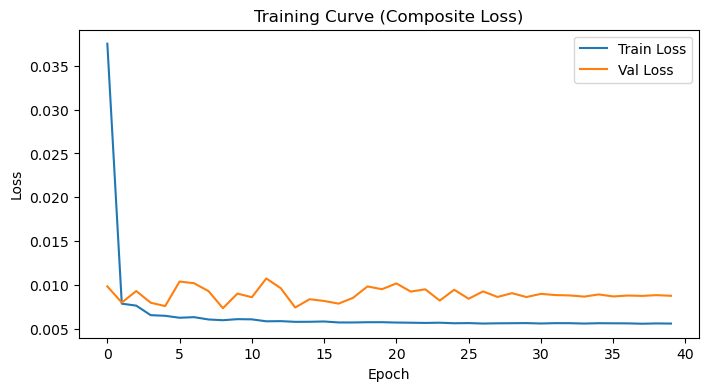

In [62]:
# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Val Loss")
plt.title("Training Curve (Composite Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [63]:
def rolling_cov_minvar(df_returns, window=20):
    """
    uses rolling sample cov of the last 'window' days
    to build a min-var portfolio each day. Returns the daily portfolio returns.
    """
    df_returns = df_returns.reset_index(drop=True)
    n_days = len(df_returns)
    n_assets_ = df_returns.shape[1]
    
    weights = []
    for t in range(n_days):
        if t < window:
            # not enough history, skip
            weights.append(np.ones(n_assets_) / n_assets_)
            continue
        
        hist = df_returns.iloc[t-window : t]
        # sample cov
        cov_mat = np.cov(hist.T)
        cov_mat += np.eye(n_assets_) * 1e-8
        
        inv_cov = np.linalg.inv(cov_mat)
        ones = np.ones((n_assets_,1))
        
        w_star = inv_cov @ ones
        denom = (ones.T @ inv_cov @ ones).item()
        w_star = (w_star / denom).flatten()
        weights.append(w_star)
    
    weights = np.array(weights)
    # compute daily returns from day t+1
    portfolio_returns = []
    for i in range(len(weights)-1):
        ret_next = df_returns.iloc[i+1].values
        pr = np.dot(weights[i], ret_next)
        portfolio_returns.append(pr)
    return np.array(portfolio_returns)

df_returns_for_baseline = df_returns.copy()
baseline_port_rets = rolling_cov_minvar(df_returns.iloc[val_end+LOOKAHEAD_DAYS:])
baseline_cum = np.cumprod(1 + baseline_port_rets) - 1

In [69]:
# Save trained model weights
torch.save(model.state_dict(), "my_factor_model_weights.pth")
print("Model weights saved to my_factor_model_weights.pth")


Model weights saved to my_factor_model_weights.pth
